In [1]:
import pandas as pd

import numpy as np
from scipy.stats import invgamma, norm
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm

from pathlib import Path
import glob
import os

In [2]:
def exponential_model(t, beta, gamma, t0):
    return beta * np.exp(gamma * (t - t0))

def compute_log_likelihood(y, t, beta, gamma, sigma, t0):
    y_pred = exponential_model(t, beta, gamma, t0)
    return np.sum(norm.logpdf(y, loc=y_pred, scale=sigma))

def gibbs_sample_sigma(y, beta, gamma, t, t0, alpha1=4, alpha2=1):
    residuals = y - exponential_model(t, beta, gamma, t0)
    N = len(y)
    alpha_post = N / 2 + alpha1
    beta_post = np.sum(residuals**2) / 2 + alpha2
    return invgamma.rvs(a=alpha_post, scale=beta_post)

def metropolis_hastings(y, t, t0=0, n_samples=5000, burn_in=500, thin=5,
                        beta_range=(0.01, 10), gamma_range=(-1, 1), proposal_sd=(0.1, 0.05)):

    samples = []
    beta, gamma = 1.0, 0.0
    sigma = 1.0

    for i in range(n_samples):
        beta_prop = np.clip(np.random.normal(beta, proposal_sd[0]), *beta_range)
        gamma_prop = np.clip(np.random.normal(gamma, proposal_sd[1]), *gamma_range)

        loglike_current = compute_log_likelihood(y, t, beta, gamma, sigma, t0)
        loglike_prop = compute_log_likelihood(y, t, beta_prop, gamma_prop, sigma, t0)

        accept_prob = np.exp(loglike_prop - loglike_current)
        if np.random.rand() < accept_prob:
            beta, gamma = beta_prop, gamma_prop

        sigma = gibbs_sample_sigma(y, beta, gamma, t, t0)

        samples.append((beta, gamma, sigma))

    # Discard burn-in and thin
    samples = samples[burn_in::thin]
    return np.array(samples)


In [67]:
def normalize_series(y):
    y = (y - np.min(y)) / (np.max(y) - np.min(y) + 1e-8)
    return y + 1  # Set minimum to 1

def sliding_window_pvalues(y, window=14):
    pvalues = []
    t = np.arange(len(y))
    y_norm = normalize_series(y)

    for start in range(len(y) - window + 1):
        t_win = t[start:start+window]
        y_win = y_norm[start:start+window]

        samples = metropolis_hastings(y_win, t_win, t0=t_win[0])
        gamma_samples = samples[:, 1]
        pval = 1 - np.mean(gamma_samples > 0)
        pvalues.append(pval)

    return np.array(pvalues)


In [3]:
# Example synthetic data
np.random.seed(42)
t_series = np.arange(60)
true_y = 2.0 * np.exp(0.1 * (t_series - 10))
y_observed = true_y + np.random.normal(0, 0.5, size=t_series.shape)

pvals = sliding_window_pvalues(y_observed, window=14)


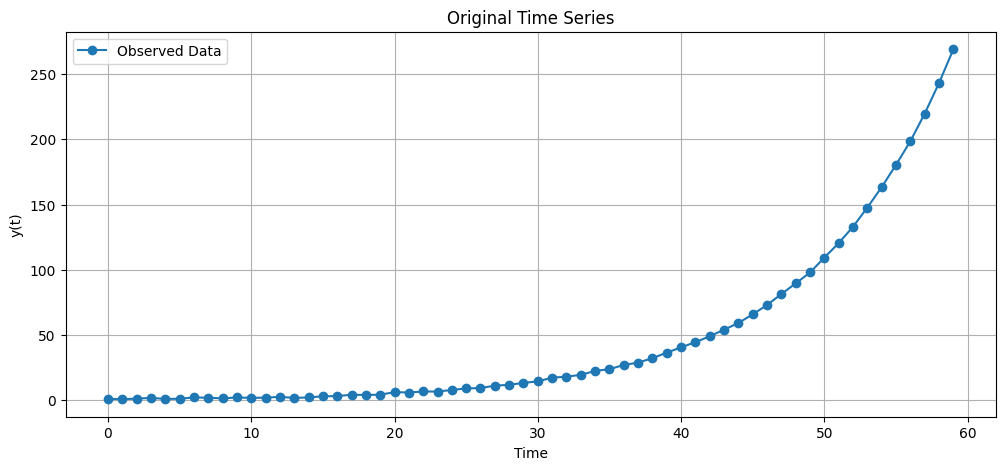

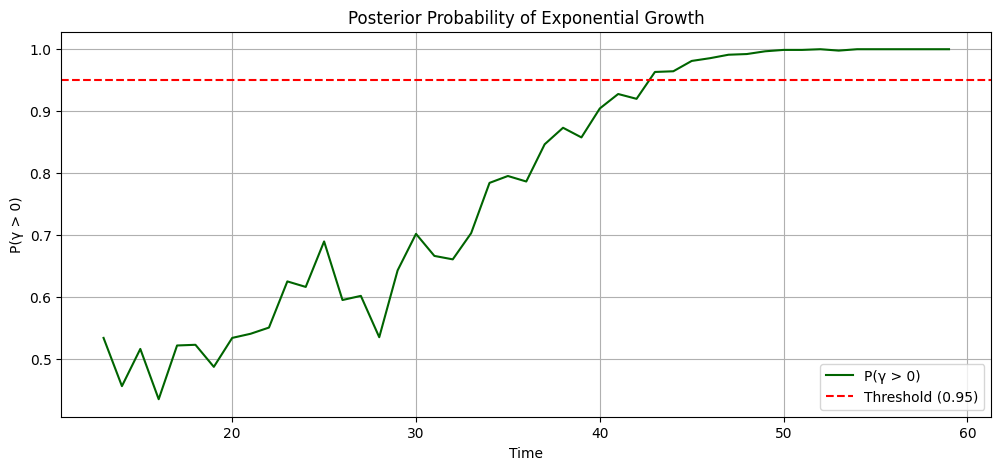

In [9]:
# Plot original series
plt.figure(figsize=(12, 5))
plt.plot(t_series, y_observed, label='Observed Data', marker='o', linestyle='-')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()


window = 14
# Plot P-values
plt.figure(figsize=(12, 5))
t_pval = np.arange(window - 1, len(y_observed))  # align with window ends
plt.plot(t_pval, 1 - pvals, label='P(γ > 0)', color='darkgreen')
plt.axhline(0.95, linestyle='--', color='red', label='Threshold (0.95)')
plt.title('Posterior Probability of Exponential Growth')
plt.xlabel('Time')
plt.ylabel('P(γ > 0)')
plt.grid(True)
plt.legend()
plt.show()


# Test model on APS data

In [45]:
mun_new = list(Path('/opt/storage/refined/aesop/visualization/')
               .glob('aesop_*_mun_new.parquet'))

aesop_mun_new = max(mun_new, key=lambda x: x.stat().st_ctime)

df = pd.read_parquet(aesop_mun_new)

In [47]:
df.columns.to_list()

['co_ibge',
 'epiyear',
 'epiweek',
 'atend_totais',
 'atend_ivas',
 'atend_arbov',
 'year_week',
 'co_uf',
 'nm_uf',
 'co_ibge7',
 'nm_municipio',
 'sigla_uf',
 'epidemi_cal_start',
 'epidemi_cal_end',
 'perc_missing',
 'perc_completude',
 'diff_2w',
 'diff_3w',
 'sum_miss',
 'completude',
 'tempestividade',
 'dqi',
 'sinal_ears_ivas',
 'lim_esp_ears_ivas',
 'prob_gro_trend_ivas',
 'lim_esp_mmaing_ivas',
 'sinal_mmaing_ivas',
 'sinal_ears_arbov',
 'lim_esp_ears_arbov',
 'prob_gro_trend_arbov',
 'num_otc_ivas',
 'lim_esp_otc_ivas',
 'sinal_otc_ivas',
 'lim_esp_evi_ivas',
 'sinal_evi_ivas',
 'exc_evi_ivas',
 'lim_esp_evi_arbov',
 'sinal_evi_arbov',
 'exc_evi_arbov',
 'pop',
 'year_week_ts',
 'ra_atend_ivas',
 'ra_atend_ivas_ma',
 'gr_ra_atend_ivas_ma',
 'ra_atend_arbov',
 'ra_atend_arbov_ma',
 'gr_ra_atend_arbov_ma',
 'sinal_ens_ivas',
 'sinal_ens_arbov',
 'lim_esp_ens_ivas',
 'lim_esp_ens_arbov',
 'alerta_vizinho',
 'sinais_vizinhos',
 'sinal_aesop_ivas',
 'co_reg_saude',
 'nm_reg_saud

In [48]:
df[df.nm_municipio == 'Salvador']

,co_ibge,epiyear,epiweek,atend_totais,atend_ivas,atend_arbov,year_week,co_uf,nm_uf,co_ibge7,...,sinal_ens_arbov_y,sinal_ens_ivas_y,vot_arbov_y,vot_ivas_y,lim_esp_ml_ivas,sinal_ml_ivas,sinal_ml_consec_ivas,sinal_ml_consec_ivas_012,exc_ml_ivas,sinal_ml_ivas_y
964252,292740,2017,1,7592,39,1,2017-01,29,Bahia,2927408,...,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,NaN
964253,292740,2017,2,9077,40,11,2017-02,29,Bahia,2927408,...,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,NaN
964254,292740,2017,3,9615,37,2,2017-03,29,Bahia,2927408,...,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,NaN
964255,292740,2017,4,9481,20,9,2017-04,29,Bahia,2927408,...,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,NaN
964256,292740,2017,5,10040,28,2,2017-05,29,Bahia,2927408,...,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964693,292740,2025,25,19167,888,1,2025-25,29,Bahia,2927408,...,0.0,0.0,NaN,NaN,1158.0,0.0,0,0,0.0,0.0
964694,292740,2025,26,15026,687,3,2025-26,29,Bahia,2927408,...,0.0,0.0,NaN,NaN,8.0,NaN,0,0,679.0,NaN
964695,292740,2025,27,25291,1078,4,2025-27,29,Bahia,2927408,...,0.0,0.0,NaN,NaN,837.0,0.0,0,0,241.0,0.5
964696,292740,2025,28,31467,1255,4,2025-28,29,Bahia,2927408,...,0.0,0.0,NaN,NaN,945.0,0.0,0,0,310.0,0.0


In [68]:
set_muni = df[df.co_ibge == 292740]

In [69]:
set_muni = set_muni[['epidemi_cal_start','year_week','atend_totais', 'atend_ivas','prob_gro_trend_ivas']]

In [70]:
set_muni = set_muni.assign(ma_atend_ivas = set_muni.atend_ivas.rolling(window=8).mean().fillna(0))

In [18]:
# Replace -inf with min finite value, +inf with max finite value
#finite_vals = set_muni['y'].replace([np.inf, -np.inf], np.nan).dropna()
#min_val = finite_vals.min()
#max_val = finite_vals.max()

#set_muni['y'] = set_muni['y'].replace({
#    -np.inf: min_val,
#    np.inf: max_val})

In [121]:
#def sliding_window_pvalues(y, window=8):
#    pvalues = []
#    t = np.arange(len(y))
#    y_norm = y + 1#normalize_series(y)
#
#    for start in range(len(y) - window + 1):
#        t_win = t[start:start+window]
#        y_win = y_norm[start:start+window]
#
#        samples = metropolis_hastings(y_win, t_win, t0=t_win[0])
#        gamma_samples = samples[:, 1]
#        pval = 1 - np.mean(gamma_samples > 0)
#        pvalues.append(pval)
#
#    return np.array(pvalues)


In [71]:
dta = set_muni[-20:]

In [72]:
pvals = sliding_window_pvalues(dta.atend_ivas.to_numpy(), window=8)

In [73]:
pvals

array([0.24111111, 0.98222222, 0.85666667, 0.41444444, 0.65888889,
       0.29777778, 0.33555556, 0.99444444, 0.94888889, 1.        ,
       0.97222222, 0.55777778, 0.41222222])

In [74]:
dta = dta.assign(pvals= [0,0,0,0,0,0,0] + pvals.tolist())

In [75]:
dta = dta.assign(P_gamma_maior_0 = 1 - dta.pvals)

In [76]:
dta[-20:][['prob_gro_trend_ivas','P_gamma_maior_0','pvals']]

,prob_gro_trend_ivas,P_gamma_maior_0,pvals
964678,0.98050,1.000000,0.000000
964679,0.99050,1.000000,0.000000
964680,0.99500,1.000000,0.000000
964681,0.99400,1.000000,0.000000
964682,0.99875,1.000000,0.000000
964683,0.99425,1.000000,0.000000
964684,0.91025,1.000000,0.000000
964685,0.79350,0.758889,0.241111
964686,0.78050,0.017778,0.982222
964687,0.57100,0.143333,0.856667


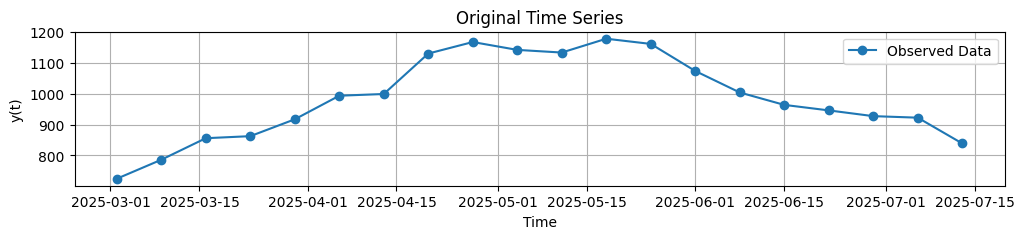

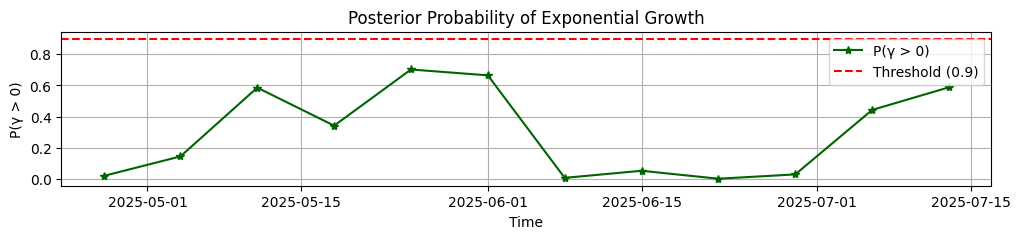

In [ ]:
dta['epidemi_cal_start'] = pd.to_datetime(dta['epidemi_cal_start'])
# Plot original series
plt.figure(figsize=(12, 2))
plt.plot(dta['epidemi_cal_start'][-30:], dta.ma_atend_ivas[-30:], label='Observed Data', marker='o', linestyle='-')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()


window = 8
# Plot P-values
plt.figure(figsize=(12, 2))
plt.plot(dta['epidemi_cal_start'][-12:], dta.P_gamma_maior_0[-12:], label='P(γ > 0)', marker='*',color='darkgreen')
plt.axhline(0.9, linestyle='--', color='red', label='Threshold (0.9)')
plt.title('Posterior Probability of Exponential Growth')
plt.xlabel('Time')
plt.ylabel('P(γ > 0)')
plt.grid(True)
plt.legend()
plt.show()

# Plot P-values
plt.figure(figsize=(12, 2))
plt.plot(dta['epidemi_cal_start'][-12:], dta.prob_gro_trend_ivas[-12:], label='Prob dash', marker='*',color='darkgreen')
plt.axhline(0.9, linestyle='--', color='red', label='Threshold (0.9)')
plt.title('Posterior Probability of Exponential Growth')
plt.xlabel('Time')
plt.ylabel('P(γ > 0)')
plt.grid(True)
plt.legend()
plt.show()